In [51]:
import numpy as np
import pandas as pd

In [70]:
# reading all the tweets
campaign_tweets = pd.read_csv('archive/Twitter/AbbottCampaign-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])
gov_tweets = pd.read_csv('archive/Twitter/GovAbbott-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])
abbot_tweets = pd.read_csv('archive/Twitter/GregAbbott_TX-tweets.csv', usecols=['Publication Year', 'Author', 'Title', 'Publication Title'])

In [57]:
campaign_tweets.groupby(['Author']).count()

,Publication Year,Title,Publication Title
Author,,,
Texans for Abbott,4,4,4
Texans for Abbott [@AbbottCampaign],24,24,24


In [73]:
# fixing author so its standard 
mask = abbot_tweets['Author'].str.contains(r'\AGreg Abbott\Z')
abbot_tweets.loc[mask, 'Author'] = abbot_tweets.loc[mask, 'Author'].str.replace('Greg Abbott', 'Greg Abbott [@GregAbbott_TX]')

mask = campaign_tweets['Author'].str.contains(r'\ATexans for Abbott\Z')
campaign_tweets.loc[mask, 'Author'] = campaign_tweets.loc[mask, 'Author'].str.replace('Texans for Abbott', 'Texans for Abbott [@AbbottCampaign]')

In [75]:
campaign_tweets.groupby(['Author']).count()

,Publication Year,Title,Publication Title
Author,,,
Texans for Abbott [@AbbottCampaign],28,28,28


In [83]:
# combine the three lists into one
tweets = pd.concat([abbot_tweets, gov_tweets, campaign_tweets], ignore_index=True)
tweets.groupby(['Author']).count()['Title']

Author
Gov. Greg Abbott [@GovAbbott]          91
Greg Abbott [@GregAbbott_TX]           68
Texans for Abbott [@AbbottCampaign]    28
Name: Title, dtype: int64

In [96]:
tweets[tweets['Publication Year'] == 2021].count()['Title']

38

In [105]:
years = [2021, 2022, 2023]
abbot_dict = {}

for year in years:
    text_year = " ".join(tweets[tweets['Publication Year'] == year]['Title'])
    abbot_dict[year] = text_year.lower()

In [132]:
def rep(s, words):
    for key in words:
        for value in words[key]:
            s = s.replace(value, key)
    return s

In [157]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
import re
from nltk.probability import FreqDist

stop_words = set(stopwords.words('english'))
new_words = {'texas', 'operation', 'lone', 'star', 'state', 'said', 'austin', 'greg', 'every', 'accross', 'since', 
             'administration', 'it', 'along', 'olivarez', 'also', 'p', 'https', 'co', 'operationlonestar'}
stop_words = stop_words.union(new_words)

tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
# tokenizer = RegexpTokenizer(r'\b(?!https)\w+\b')

pattern = [r'\bfox\snews\b', r'\brio\sgrande\b', r'\bnational\sguard\b']
year_freqs = {}
total_words = []

# define words to replace
words_to_replace = {
    'dps': ['department of public safety', 'txdps', 'txdeptpublicsafety'],
    'abbott': ['governor abbott', 'governor'],
    'biden': ['president biden', 'president'],
    'trafficking': ['human trafficking'],
    'lieutenant': ['lt'],
    'continue': ['continues'],
    'texas': ['tx']
}

for year, text in abbot_dict.items():
    
    # replace similar words and phrases together
    t = rep(text, words_to_replace)
    
    tokens = tokenizer.tokenize(t)
    new_tokens = []
    
    for i in range(len(tokens)):
        if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
            new_tokens.append(tokens[i] + " " + tokens[i+1])
        else:
            new_tokens.append(tokens[i])
    
    filtered_tokens = [token for token in new_tokens if token not in stop_words]
    total_words.append(len(tokens))
    fdist = FreqDist(filtered_tokens)
    year_freqs[year] = fdist
    
    
for k, v in year_freqs.items():
    print(k, ':')
    for word, frequency in v.most_common(30):
        print(f"{word}: {frequency}")
    print()

2021 :
border: 53
dps: 22
secure: 18
guard: 17
biden: 14
illegal: 13
national guard: 12
safe: 12
immigrants: 11
keep: 9
crisis: 8
arrests: 8
texasguard: 8
continue: 7
communities: 7
criminal: 7
safety: 6
working: 6
seized: 6
lbs: 6
support: 5
southern: 5
dept: 5
public: 5
made: 5
patrol: 5
referrals: 5
surge: 4
human: 4
policies: 4

2022 :
border: 147
biden: 87
continue: 53
secure: 48
fentanyl: 45
migrants: 43
communities: 32
dps: 32
doses: 30
seized: 30
criminal: 29
illegal: 25
drugs: 24
arrests: 24
crisis: 24
open: 23
bused: 23
sanctuary: 23
cities: 23
lethal: 23
policies: 22
deadly: 21
texans: 20
nyc: 19
protect: 17
gaps: 17
stepping: 17
pres: 17
safe: 16
dangerous: 16

2023 :
border: 39
biden: 26
deadly: 18
secure: 14
fentanyl: 11
illegal: 10
seized: 10
doses: 10
drugs: 10
million: 8
open: 8
policies: 8
dps: 8
weapons: 8
abbott: 8
gregabbott_texas: 8
stop: 7
working: 7
continue: 7
criminal: 7
arrests: 7
crisis: 6
texans: 5
texasmilitary: 5
immigrants: 5
country: 5
migrants: 5
dange

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

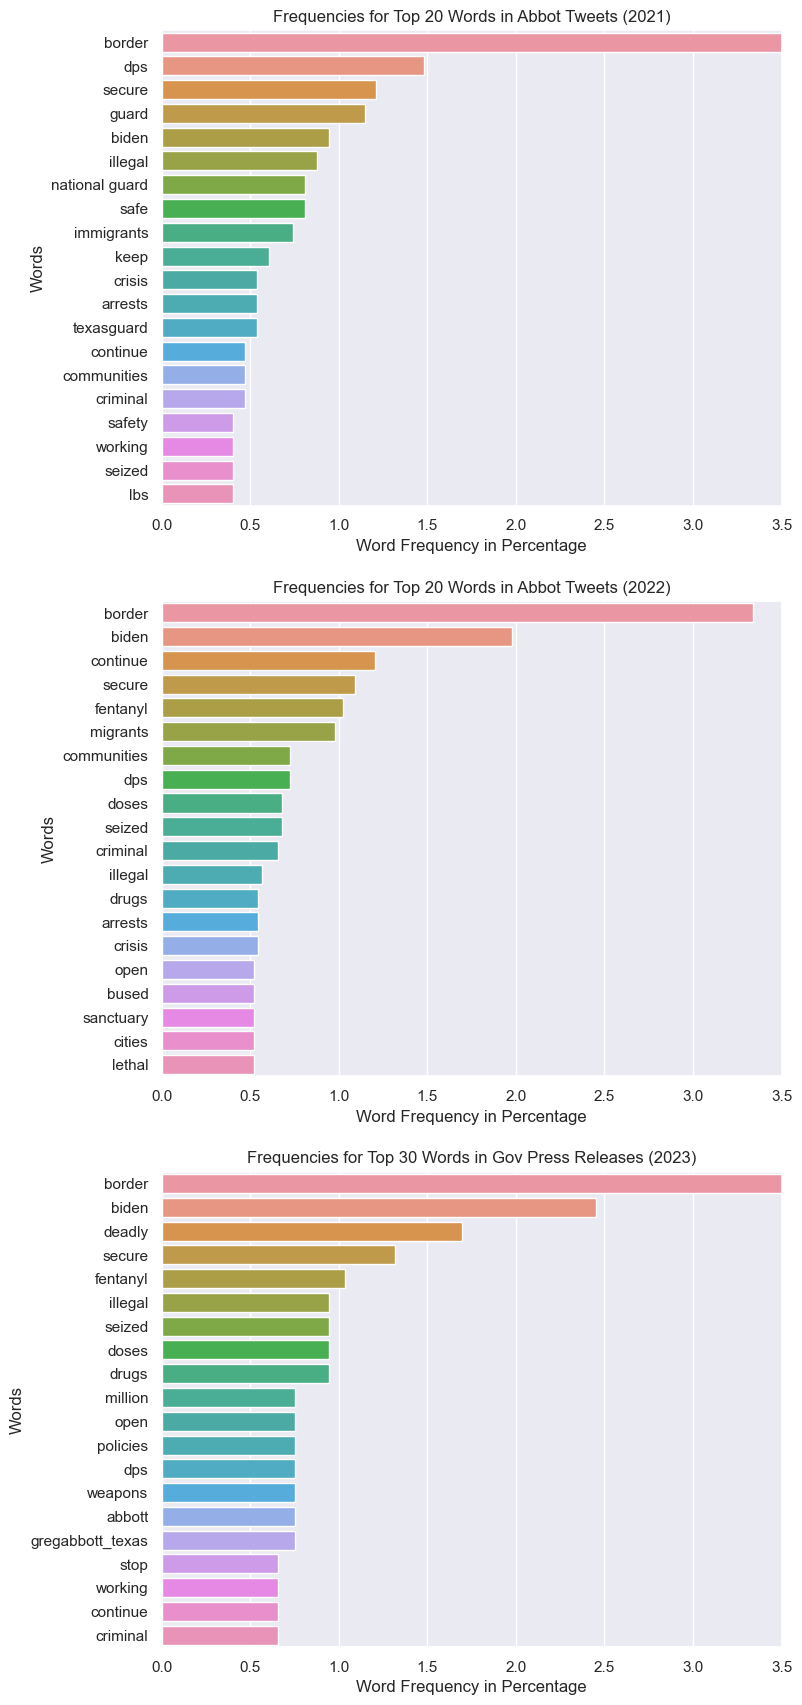

In [159]:
top_words_2021 = [(k ,(v/total_words[0])*100) for k, v in year_freqs[2021].most_common(20)]
top_words_2022 = [(k ,(v/total_words[1])*100) for k, v in year_freqs[2022].most_common(20)]
top_words_2023 = [(k ,(v/total_words[2])*100) for k, v in year_freqs[2023].most_common(20)]


# Create a bar plot of the most common words
fig, axes = plt.subplots(3,1,figsize=(8,21))
sns.set(style="darkgrid")
sns.barplot(ax = axes[0], 
            x=[w[1] for w in top_words_2021], 
            y=[w[0] for w in top_words_2021])
axes[0].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Abbot Tweets (2021)')
axes[0].set_xlim(0,3.5)

sns.barplot(ax = axes[1], 
            x=[w[1] for w in top_words_2022], 
            y=[w[0] for w in top_words_2022])
axes[1].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 20 Words in Abbot Tweets (2022)')
axes[1].set_xlim(0,3.5)

sns.barplot(ax = axes[2], 
            x=[w[1] for w in top_words_2023], 
            y=[w[0] for w in top_words_2023])
axes[2].set(xlabel='Word Frequency in Percentage',
            ylabel='Words',
            title='Frequencies for Top 30 Words in Gov Press Releases (2023)')
axes[2].set_xlim(0,3.5)

plt.savefig('images/Tweets/Gov_freqs_years.png', bbox_inches='tight')
plt.show()

In [153]:
all_text = " ".join(tweets['Title']).lower()

all_text = rep(all_text, words_to_replace)

tokens = tokenizer.tokenize(all_text)

new_tokens = []
for i in range(len(tokens)):
    if i < len(tokens)-1 and re.match(pattern[0], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[1], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    elif i < len(tokens)-1 and re.match(pattern[2], tokens[i] + " " + tokens[i+1]):
        new_tokens.append(tokens[i] + " " + tokens[i+1])
    else:
        new_tokens.append(tokens[i])

filtered_tokens = [token for token in new_tokens if token not in stop_words]
total_words = len(tokens)
fdist = FreqDist(filtered_tokens)
total_freqs = fdist


for word, frequency in total_freqs.most_common(10):
    print(f"{word}: {frequency}")

border: 239
biden: 127
secure: 80
continue: 67
dps: 62
fentanyl: 58
migrants: 50
illegal: 48
seized: 46
criminal: 43


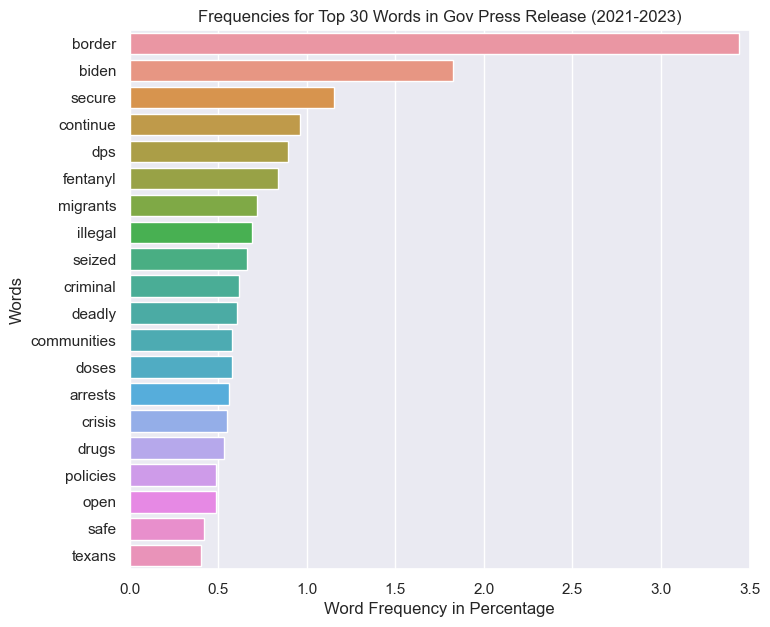

In [155]:
top_words = [(k ,(v/total_words)*100) for k, v in total_freqs.most_common(20)]

# Create a bar plot of the most common words
fig, ax = plt.subplots(1,1,figsize=(8,7))
sns.set(style="darkgrid")
sns.barplot(ax=ax,
            x=[w[1] for w in top_words], 
            y=[w[0] for w in top_words])
ax.set(xlabel='Word Frequency in Percentage',
       ylabel='Words',
       title='Frequencies for Top 30 Words in Gov Press Release (2021-2023)')
ax.set_xlim(0,3.5)

plt.savefig('images/Tweets/Gov_freqs_all.png', bbox_inches='tight')
plt.show()